In [1]:
import pandas as pd
import re
from scipy.signal import correlate
import numpy as np
import sys
sys.path.append(r'C:\Users\clima\Desktop\Aptamers\src')
import time
from sklearn.manifold import TSNE
from sklearn.cluster import OPTICS
import os
from APTamers import  Aptamer_Fold
from tqdm import tqdm
from utils import check_char, check_if_string, check_structure, check_empty_or_short, find_substrings,  attach_stems
import pandas as pd
import forgi.visual.mplotlib as fvm
import forgi
from forgi.graph.bulge_graph import BulgeGraph
import matplotlib.pyplot as plt
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.cluster import SpectralClustering

In [ ]:
def find_consecutive_dots(string):
    dot_locations = []  # List to store locations of consecutive dots
    consecutive_dots = []  # List to store consecutive dot sequences
    for i, char in enumerate(string):
        if char == '.':
            dot_locations.append(i)
        else:
            if len(dot_locations) > 0:
                consecutive_dots.append(dot_locations)
            dot_locations = []
    return consecutive_dots

def bag_of_sequences(subsequence, sequence, consecutive_dots):
    desc = np.zeros(len(subsequence), dtype = int)
    for count, sub in enumerate(subsequence):
        for m in consecutive_dots:
                lis =  ''.join([sequence[n] for n in m])
                if sub in lis:
                    desc[count]+=1
    return desc
                    
def descriptors(sequence, structure):
    consecutive_dots = find_consecutive_dots(structure)
    return bag_of_sequences(subsequence, sequence, consecutive_dots)
    
    
def compute_descriptor_motzkin(input_string):
    descriptor = []
    sum = 0
    for count, char in enumerate(input_string):
        if char == '(':
            sum +=1
            descriptor.append(sum)
        elif char == ')':
            sum -=1 
            descriptor.append(sum)
        elif char == '.':
            descriptor.append(sum)      
    return descriptor



def dna_descriptor(sequence, n_max):
    # Create an array of zeros with the same length as the sequence
    complete_descriptor = []
    for l in ['A', 'C', 'T', 'G']:
        descriptor = np.zeros(len(sequence), dtype=int)
        descriptor[ np.where(np.array(list(sequence)) == l)[0]] = 1
        
        complete_descriptor +=descriptor.tolist()
        complete_descriptor+=np.zeros(n_max -len(sequence), dtype=int).tolist()
    return np.asarray(complete_descriptor)  

In [2]:
def compute_descriptor(input_string):
    descriptor = []
    sum = 0
    for  char in input_string:
        if char == '(':
            sum +=1
            descriptor.append(sum)
        elif char == ')':
            sum -=1 
            descriptor.append(sum)
        elif char == '.':
            descriptor.append(sum)      
    return descriptor


In [13]:
df = pd.read_csv(r'C:\Users\clima\Desktop\Aptamers\data\preprocessed _files\merged_all.csv')
print('Numeber sequences after merge:',len(df))
df = df.drop_duplicates(subset='Sequence')
print('Numeber of unique sequences after merge:',len(df))
df.head()

df['Descriptor'] = df['Structure_graph_match'].apply(lambda x: compute_descriptor(x) )
df['Descriptor'] = df['Descriptor'] .apply(lambda x: np.array(x[8:-8]))
percentile_95 = np.percentile(df['Descriptor'].apply(len), 95) 
percentile_3 = np.percentile(df['Descriptor'].apply(len), 5)
# Filter DataFrame to remove rows with list lengths outside the 95th percentile
df = df[df['Descriptor'].apply(len).between(np.floor(percentile_3)+1, np.ceil(percentile_95))]


print(len(df))
df = df.reset_index()


Numeber sequences after merge: 9131
Numeber of unique sequences after merge: 4933
4450


In [15]:
indices_of_highest = df.nlargest(100, 'Count').index
# Determine the maximum length of the lists
max_length = df['Descriptor'].apply(len).max()

# Convert the lists column into a numpy array with padding
X = np.zeros((len(df), max_length), dtype=int)
for i, row in enumerate(df['Descriptor']):
    X[i, :len(row)] = row

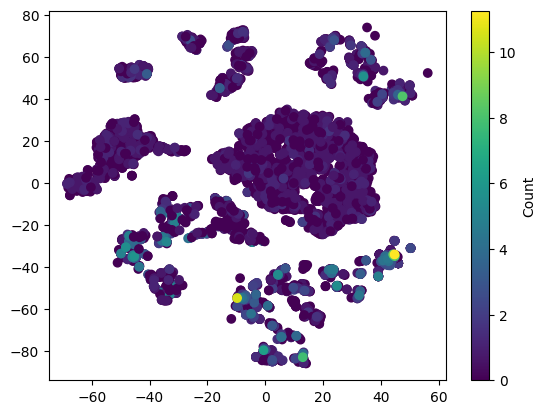

In [16]:



X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=30).fit_transform(X)
plt.scatter(X_embedded[::-1,0], X_embedded[::-1,1],c=np.log(df['Count'][::-1]), cmap='viridis')
plt.colorbar(label='Count')
plt.show()


In [ ]:

def substructure_ID(string):
    w= compute_descriptor(string)
    
    dct = {'hairpins' : [],
    'multi-branches' : [],
    'stacks' : [],
    'left_bulges' : [],
    'right_bulges' : [],
    'inner_loops' : [] }
    
    stacks = []
    for count, s in enumerate(string):
        if s == '(':
            stacks.append(count)
            
        elif s == ')':
            i = stacks.pop(-1)
            j = count
            
            if w[i]==w[i+1]-1 and w[j]==w[j-1]-1:
                dct['stacks'].append((i,j))
                
            else:
                l = w[j]
                L = np.where(w[i:j]== l+1)[0]
                T =len(L)/2
                stat = [i] + list(L) + [j]
                if T == 0:
                    dct['hairpins'].append((i,j))
                elif T == 1:
                    if w[i]==w[i+1]-1 and w[j]!=w[j-1]-1: #right buldge
                        dct['left_buldges'].append([(stat[k], stat[k-1]) for k in range(len(stat)/2-1)])
                        #dct['right_buldges'].append((i,j))
                    elif w[i]!=w[i+1]-1 and w[j]==w[j-1]-1: #left buldge
                        dct['left_buldges'].append([(stat[k], stat[k-1]) for k in range(len(stat)/2-1)])
                        #dct['left_buldges'].append((i,j))
                    else:
                        dct['inner_loops'].append([(stat[k], stat[k-1]) for k in range(len(stat)/2-1)])
                        #dct['inner_loops'].append((i,j))
                elif T > 1:
                    dct['multi-branches'].append([(stat[k], stat[k-1]) for k in range(len(stat)/2-1)])